<a href="https://colab.research.google.com/github/mellygsln/PortofolioProjek/blob/main/Gabungan_1_5_Melly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom, norm, beta, expon
import warnings
warnings.filterwarnings("ignore")
import random
from scipy.stats import entropy

Data yang dipake
1. Jumlah kasus TB per kab/kota 2023
2. Banyak Xpert di file utilisasi
3. Total populasi pake tahun 2020 dari habib
4. Data positivity RR pake 2022

27 kota dari utilitas
Melly 1-5
Arro 6-11
Fanny 12-17
Iko 18-22
Shio 23-27


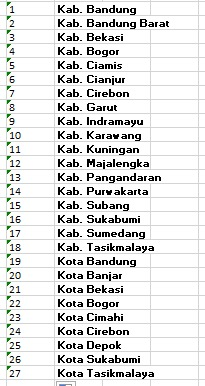

In [ ]:
data_Tb = pd.read_excel("DataNedeed1-5.xlsx", sheet_name="Kasus TB")
data_x = pd.read_excel("DataNedeed1-5.xlsx", sheet_name="Banyak Xpert")
data_N = pd.read_excel("DataNedeed1-5.xlsx", sheet_name="Jumlah Penduduk")

In [ ]:
Tb = data_Tb[["Januari","Februari","Maret","April","Mei","Juni","Juli","Agustus","September","Oktober","November","Desember" ]].values.tolist()

In [ ]:
Tb[0]

[1328, 1166, 1268, 1013, 1418, 1106, 1192, 1443, 1438, 1441, 1198, 988]

In [ ]:
x = data_x["Jumlah Alat"]

In [ ]:
N = data_N["Jumlah Penduduk"]
N

0    3831505
1    1714982
2    3075690
3    1126927
4    1201685
Name: Jumlah Penduduk, dtype: int64

In [ ]:
nama = ["Kab. Bandung", "Kab. Badnung Barat", "Kab. Bekasi", "Kab. Bogor", "Kab. Ciamis"]

In [ ]:
nama[0]

'Kab. Bandung'

# Model

$n_i \sim POISSON(\gamma_i N_i)$<br>
$logit(\gamma_i) = \sigma_i + \alpha_i x_i$<br>
$y_i \sim Binomial(n_i, \beta_i)$<br>

with:
* $\gamma_i$ : testing rate
* $\beta_i$ : positivity rate
* $x_i$ : # of Xpert in region $i$

In [ ]:
# Model

# Likelihood function for normal distribution
def likelihood(y1, x, N, sigma, alpha, beta):
    m = len(y1)
    n = np.random.poisson(logistic(sigma + alpha*x)*N, m)
    y = np.random.binomial(n, beta)

    RMSE = np.sum((y-y1)**2)/np.sum(y1)
    likelihood = np.exp(-RMSE/np.std(y1))
    return likelihood

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Prior distribution for mu and sigma
def prior(sigma, alpha, beta_param):
    a = -5
    b = 2
    c = 0.1
    d = 2
    e = 10
    sigma_prior = norm.pdf(sigma, loc=a, scale=b)
    alpha_prior = expon.pdf(alpha, scale=c)
    beta_prior = beta.pdf(beta_param, d, e)
    return sigma_prior*alpha_prior*beta_prior

# Metropolis-Hastings algorithm
def metropolis_hastings(y, x, N, n_samples, initial_params, proposal_variances):
    samples = [initial_params]
    current_params = initial_params
    current_likelihood = likelihood(y, x, N, *initial_params)

    for _ in range(n_samples):
        proposed_params = current_params + np.random.normal(0, proposal_variances, size=len(initial_params))
        while (proposed_params[2] < 0)or(proposed_params[2] > 1)or(proposed_params[1] < 0):
            proposed_params = current_params + np.random.normal(0, proposal_variances, size=len(initial_params))

        proposed_likelihood = likelihood(y, x, N, *proposed_params)

        # Calculate the acceptance ratio
        alpha = (proposed_likelihood * prior(*proposed_params)) / (current_likelihood * prior(*current_params))
#         print(alpha)

        # Accept or reject
        u = np.random.uniform()
        if u < alpha:
            current_params = proposed_params
            current_likelihood = proposed_likelihood
#         print(current_likelihood)
        samples.append(current_params)

    return np.array(samples)

# Implementasi

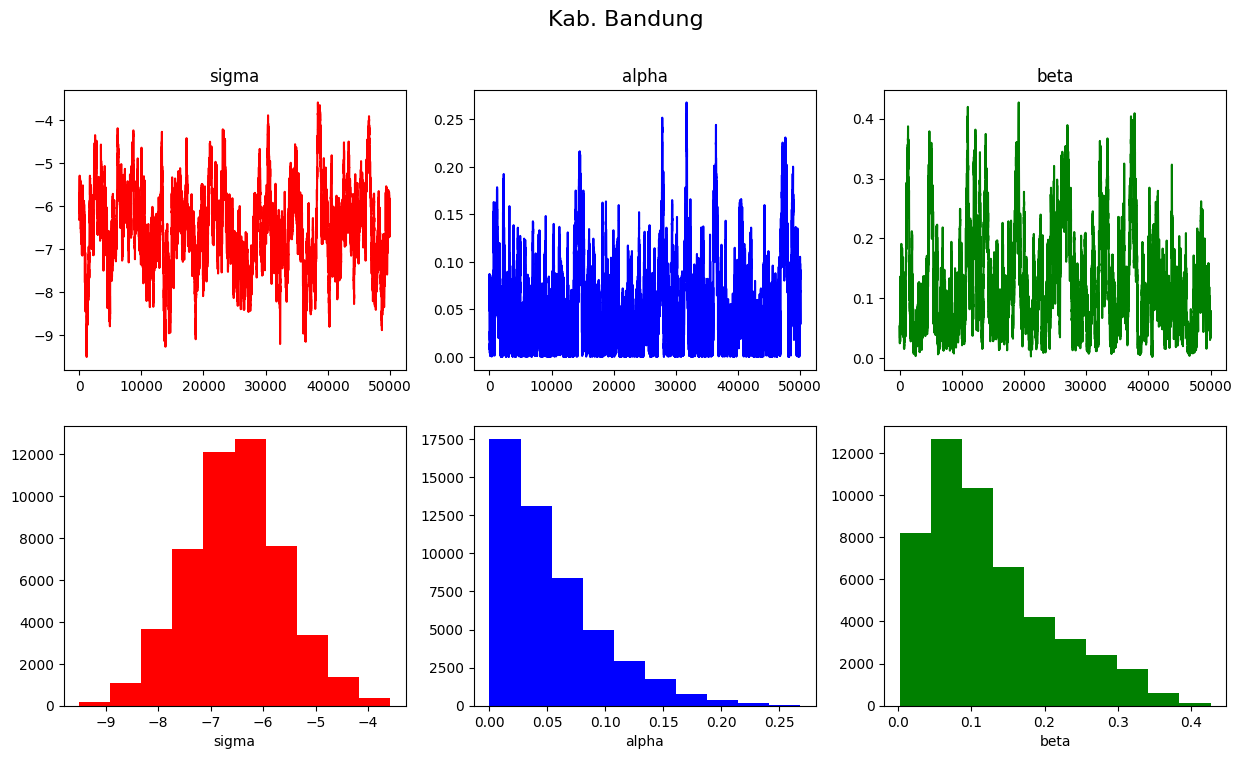

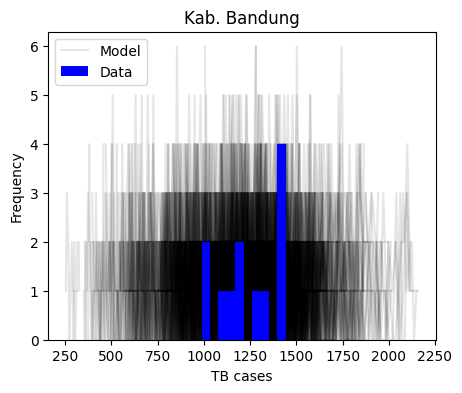

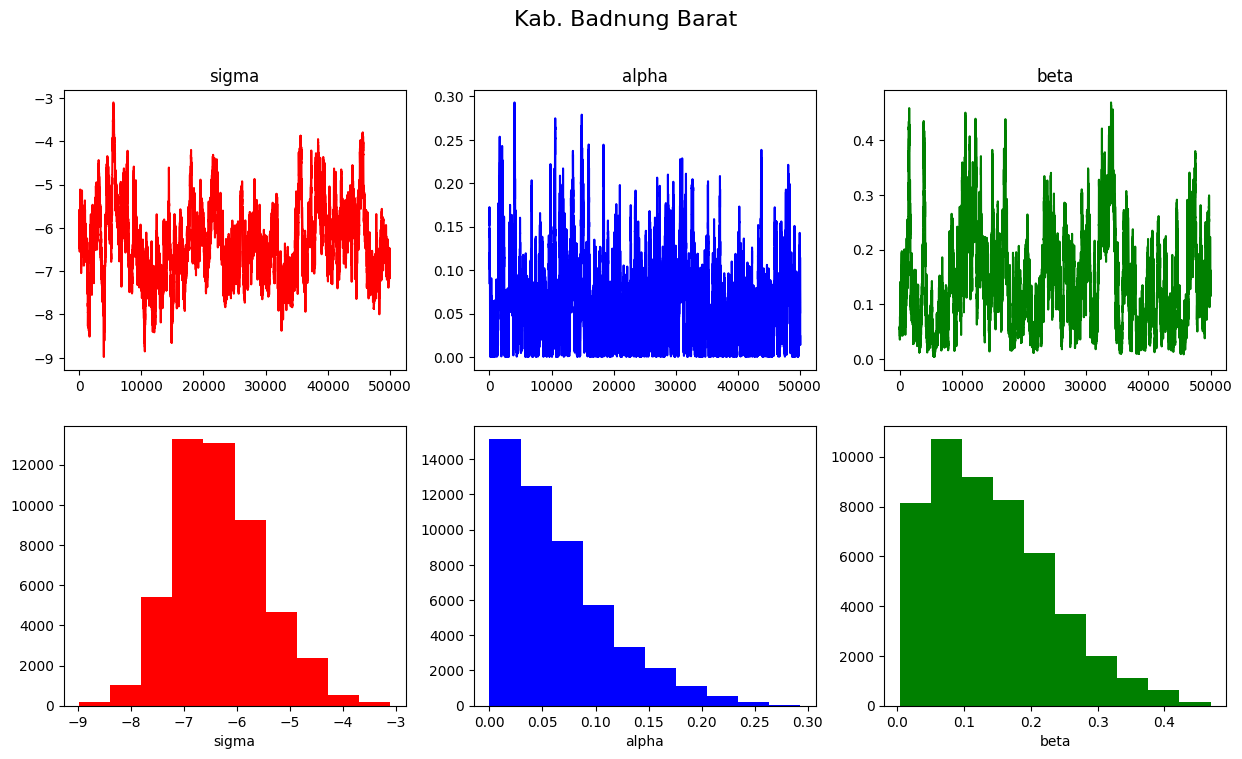

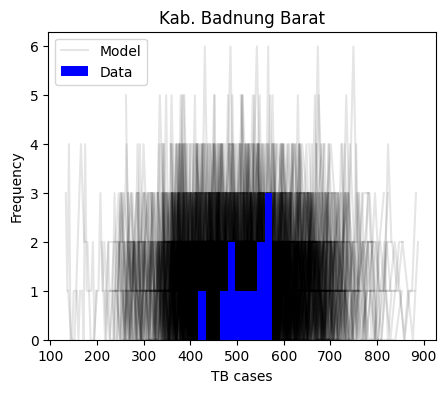

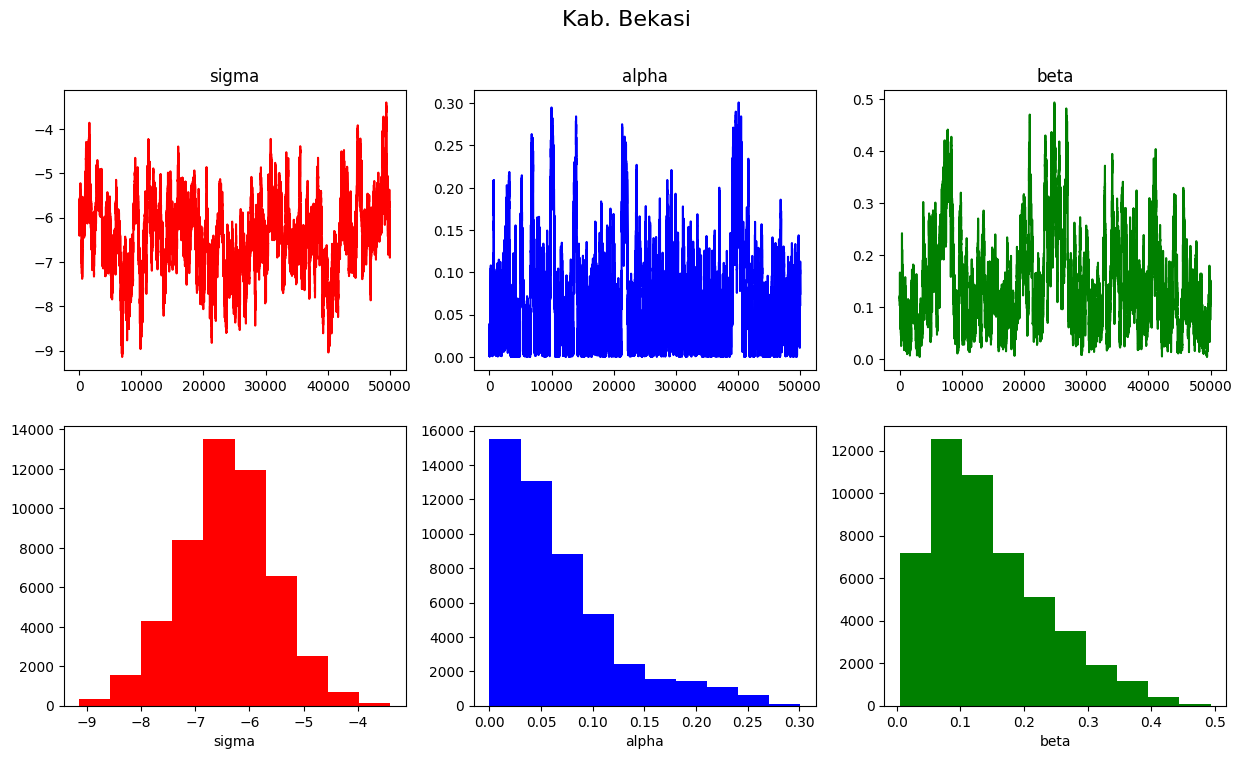

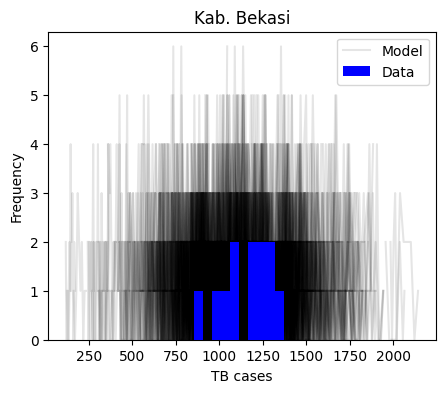

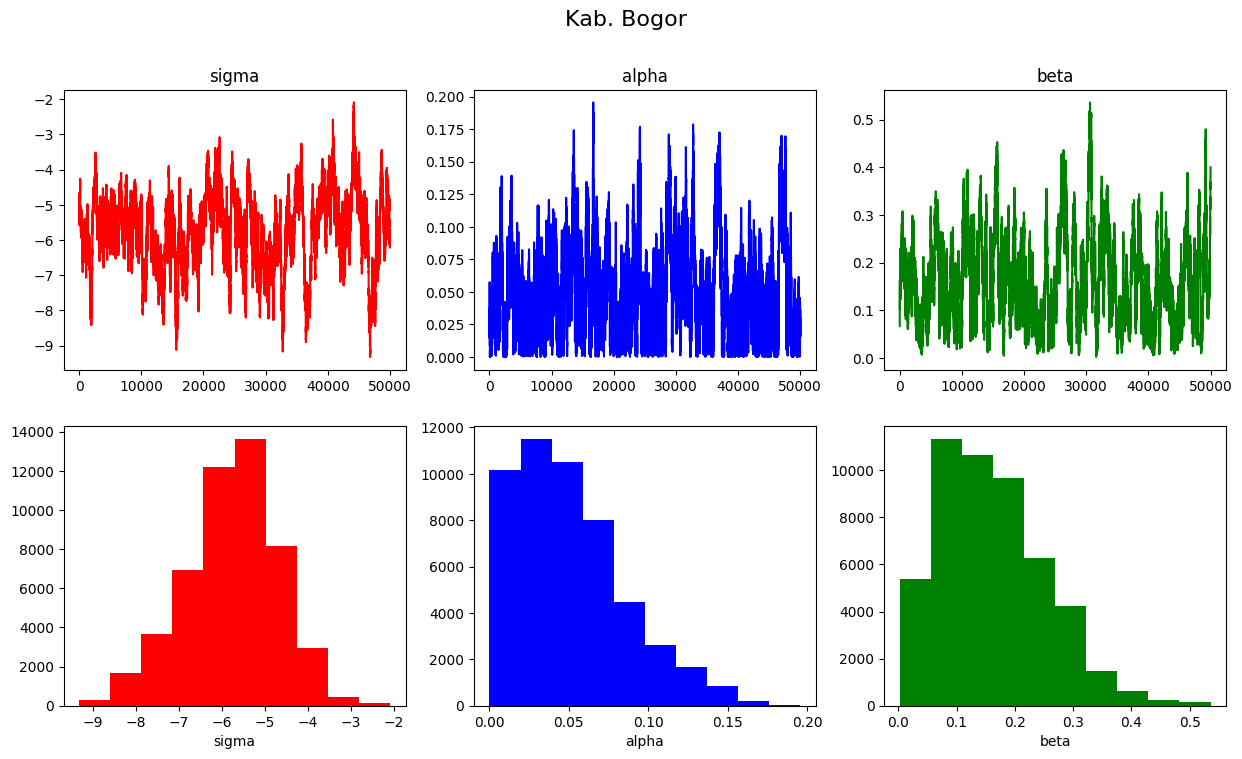

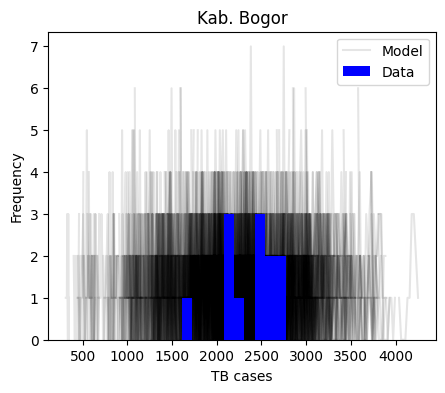

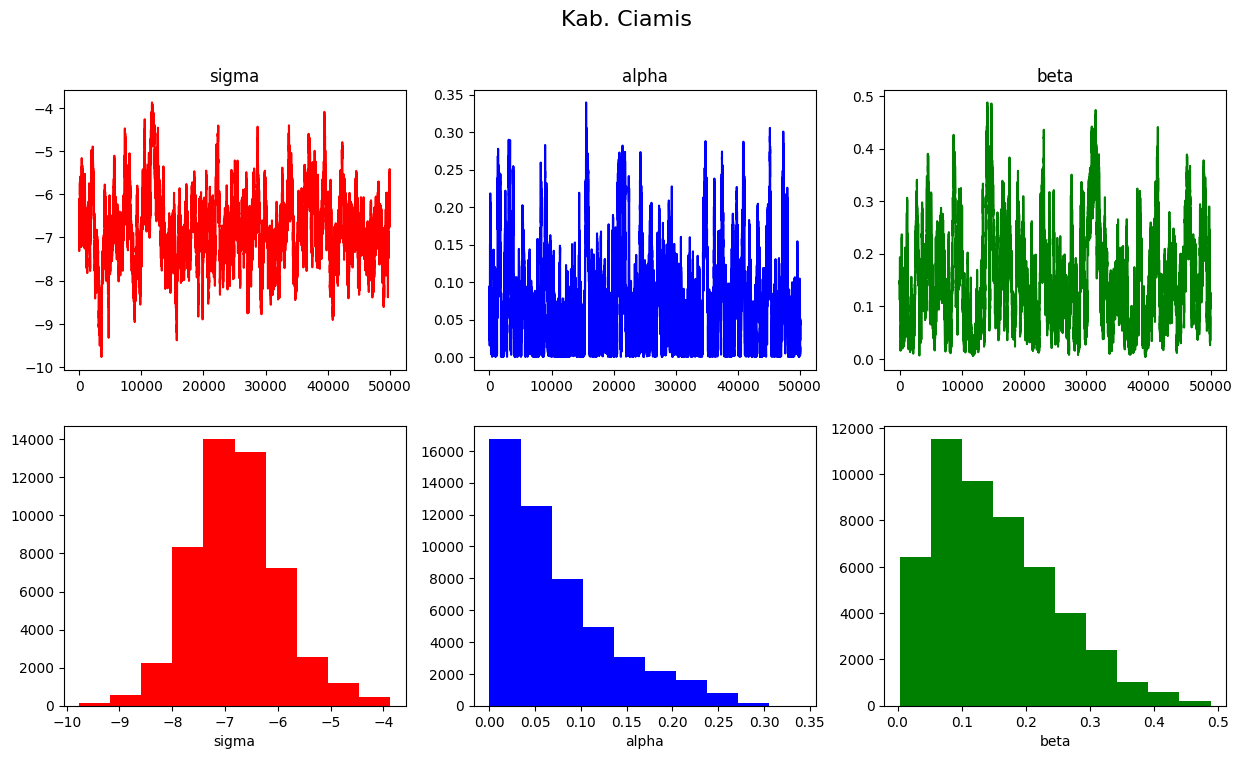

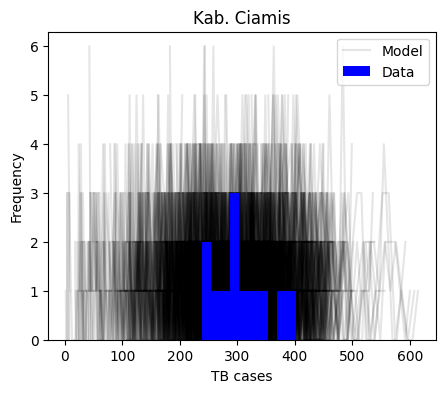

In [ ]:
# Set Metropolis-Hastings parameters
n_samples = 100000
burn = 0.5*n_samples
initial_params = [-5, 0.01, 0.01]  # Set initial values
proposal_variances = [0.1, 0.01, 0.01]  # This is steps factor. When you set this values higher, then your model will increase their search space.
samples_arr = []
realizations_arr = []
# Run the MH
for k in range(5):
  np.random.seed(1)
  y = Tb[k]
  samples = metropolis_hastings(y, x[k], N[k], n_samples, initial_params, proposal_variances)
  samples_arr.append(np.array(samples[int(burn):]))
  # Visualization
  fig, axs = plt.subplots(2, 3, figsize=(15, 8))
  for i in range(3):
      axs[0, i].plot(samples[int(burn):, i], color=["red", "blue", "green"][i])
      axs[0, i].set(title=["sigma", "alpha", "beta"][i])

  for i in range(3):
      axs[1, i].hist(samples[int(burn):, i], color=["red", "blue", "green"][i])
      axs[1, i].set(xlabel=["sigma", "alpha", "beta"][i])
  fig.suptitle(f"{nama[k]}", fontsize=16)
  plt.show()

  def modelGen(Tb, x, N, sigma, alpha, beta):
    m = len(Tb)
    n = np.random.poisson(logistic(sigma + alpha*x)*N, m)
    y = np.random.binomial(n, beta)
    return y

  NumSample = 1000
  realizations = np.array([])
  bins = np.array([])
  histbar = np.array([])
  for i in range(NumSample):
      Idx = random.randint(1, n_samples-burn)
      params = samples[int(burn)+Idx, :]
      realizations = np.append(realizations, modelGen(Tb[k], x[k],N[k], *params)).reshape(-1,len(Tb[k]))
      histbar_temp, bins_temp = np.histogram(modelGen(Tb[k], x[k], N[k], *params), bins=10)
      bins = np.append(bins, bins_temp).reshape(-1,len(bins_temp))
      histbar = np.append(histbar, histbar_temp).reshape(-1,len(histbar_temp))

  realizations_arr.append(np.array(realizations))
  # Visual
  fig = plt.figure(figsize  = (5,4))
  plt.plot(bins[0,:-1], histbar[0,:], color='black', alpha=0.1, label="Model")
  for i in range(NumSample):
      plt.plot(bins[i,:-1], histbar[i,:], color='black', alpha=0.1)
  plt.hist(Tb[k], zorder=10, color="blue", label="Data")
  plt.xlabel("TB cases")
  plt.ylabel("Frequency")
  plt.title(f"{nama[k]}")
  plt.legend()
  plt.show()

In [ ]:
#Simpan data sigma, alpha, beta
for j in range(5):
  w= samples_arr[j]
  df1 = pd.DataFrame({
      "sigma": w[:, 0],
      "alpha": w[:, 1],
      "beta": w[:, 2],
  })
  df1.to_excel("parameter "+f"{nama[j]}.xlsx", index=False)

In [ ]:
for j in range(5):
  w= realizations_arr[j]
  df2 = pd.DataFrame({
      "Jan": w[:, 0],
      "Feb": w[:, 1],
      "Mar": w[:, 2],
      "Apr": w[:, 3],
      "May": w[:, 4],
      "Jun":w[:, 5],
      "Jul":w[:, 6],
      "Aug":w[:, 7],
      "Sep":w[:, 8],
      "Okt":w[:, 9],
      "Nov":w[:, 10],
      "Dec":w[:, 11],
  })
  df2.to_excel("kasus "+f"{nama[j]}.xlsx", index=False)

In [ ]:
#Mean dan Standar Deviasi masing-masing parameter
rataan = np.array([])
std_dev = np.array([])
for i in range(5):
  parameter = samples_arr[i]
  rataan = np.append(rataan, np.mean(parameter,axis=0)).reshape(-1,3)
  std_dev = np.append(std_dev, np.std(parameter, axis =0)).reshape(-1,3)
rataan

array([[-6.52993518,  0.05254449,  0.12384172],
       [-6.32469202,  0.06359995,  0.14141828],
       [-6.41079796,  0.06654996,  0.1440439 ],
       [-5.76761817,  0.05069171,  0.16150439],
       [-6.79628681,  0.07253094,  0.15104222]])

In [ ]:
std_dev

array([[0.92158909, 0.04351834, 0.08431917],
       [0.85657555, 0.05006456, 0.08929273],
       [0.8635418 , 0.05697024, 0.09013814],
       [1.07633643, 0.03449719, 0.09079145],
       [0.83294366, 0.06136209, 0.0925473 ]])

In [ ]:
df = pd.DataFrame({
    "Nama Kab": nama,
    "rataan_sigma": rataan[:, 0],
    "rataan_alpha": rataan[:, 1],
    "rataan_beta": rataan[:, 2],
    "std_sigma": std_dev[:, 0],
    "std_alpha": std_dev[:, 1],
    "std_beta": std_dev[:, 2]
})


In [ ]:
df

,Nama Kab,rataan_sigma,rataan_alpha,rataan_beta,std_sigma,std_alpha,std_beta
0,Kab. Bandung,-6.529935,0.052544,0.123842,0.921589,0.043518,0.084319
1,Kab. Badnung Barat,-6.324692,0.063600,0.141418,0.856576,0.050065,0.089293
2,Kab. Bekasi,-6.410798,0.066550,0.144044,0.863542,0.056970,0.090138
3,Kab. Bogor,-5.767618,0.050692,0.161504,1.076336,0.034497,0.090791
4,Kab. Ciamis,-6.796287,0.072531,0.151042,0.832944,0.061362,0.092547


In [ ]:
df.to_excel('data.xlsx', index=False)

In [ ]:
data_pos1 = pd.read_excel("DataNedeed1-5.xlsx", sheet_name="posRR")
data_pos2 = pd.read_excel("DataNedeed1-5.xlsx", sheet_name="posMTB")
posRR = np.array(data_pos1[["Januari","Februari","Maret","April","Mei","Juni","Juli","Agustus","September","Oktober","November","Desember" ]].values.tolist())/100
posMTB = np.array(data_pos2[["Januari","Februari","Maret","April","Mei","Juni","Juli","Agustus","September","Oktober","November","Desember" ]].values.tolist())/100

In [ ]:
np.mean(posRR,axis=1)


array([0.05495833, 0.05665833, 0.07815   , 0.08230833, 0.06625833])

In [ ]:
np.mean(posMTB, axis=1)

array([0.19983333, 0.13851667, 0.31734167, 0.265825  , 0.10508333])

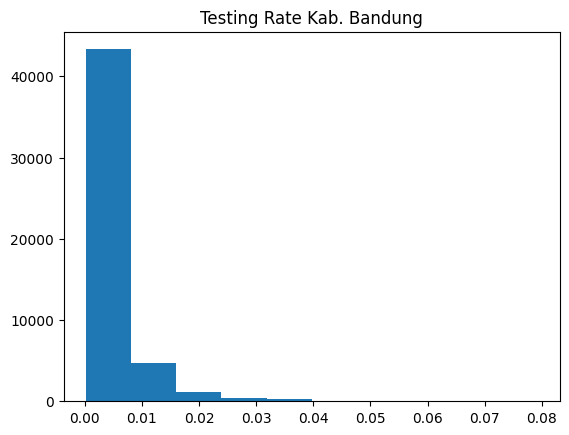

mean: 0.004668820006128155


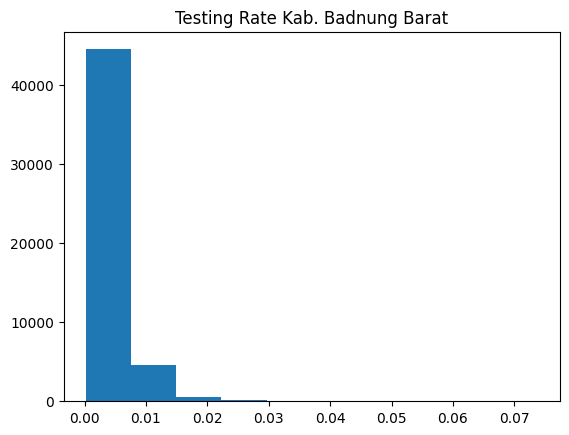

mean: 0.0037829448576686946


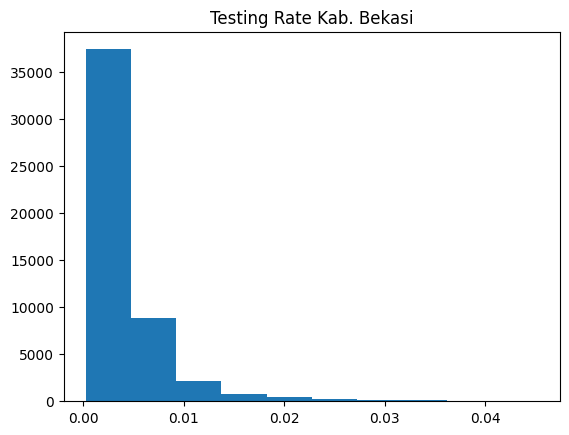

mean: 0.004079780460904358


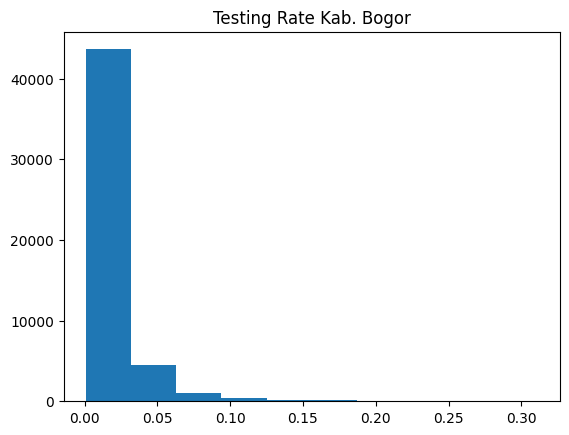

mean: 0.01953952469855024


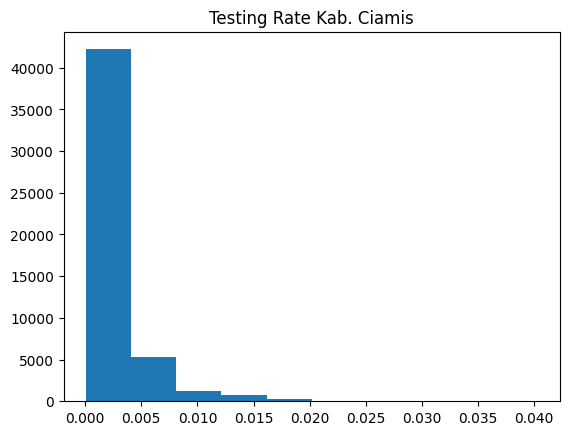

mean: 0.00266464391223437


In [ ]:
#Testing Rate
for v in range(5):
  parameter = samples_arr[v]
  sigma = parameter[:,0]
  alpha = parameter[:,1]
  gamma = logistic(sigma + alpha*x[v])
  plt.hist(gamma)
  plt.title("Testing Rate "+f"{nama[v]}")
  plt.show()
  print("mean:", np.mean(gamma))

In [ ]:
parameter = samples_arr[0]
sigma = parameter[:,0]
alpha = parameter[:,1]
gamma = logistic(sigma + alpha*x[0])

In [ ]:
np.mean(gamma)

0.004668820006128155

In [ ]:
gamma = np.array([])
for i in range(len(samples_arr[0])):
  parameter = samples_arr[0]
  sigma = parameter[i][0]
  alpha = parameter[i][1]
  gamma = np.append(gamma, logistic(sigma + alpha*x[0]))
np.mean(gamma)

0.004668820006128155

In [ ]:
logistic(-6.41816 +0.073602*x[3])*N[3]*0.125624

2070.8351931572265

In [ ]:
#Prediksi Banyak Orang yang di Tes
for i in range(5):
  sigma = rataan[i][0]
  alpha = rataan[i][1]
  yy = np.random.poisson(logistic(sigma + alpha*x[i])*N[i], 12)
  print(yy)

[12273 12264 12245 12316 12248 12152 12383 12267 12257 12308 12366 12221]
[4522 4540 4528 4474 4535 4657 4495 4715 4584 4419 4464 4429]
[9112 9152 9228 9226 9170 9179 9120 9070 9198 9166 9298 9220]
[15718 16017 15864 15867 15952 15755 15782 16032 15780 15569 16104 16016]
[2172 2192 2199 2266 2245 2273 2316 2247 2241 2138 2240 2209]


In [ ]:
predict = np.array([])
for i in range(5):
  z = np.mean(realizations_arr[i], axis=0)
  predict = np.append(predict,z).reshape(-1,12)

In [ ]:
df = pd.DataFrame(predict)

In [ ]:
df.to_excel("kasus.xlsx", index=False)

In [ ]:
rataan

array([[-6.52993518,  0.05254449,  0.12384172],
       [-6.32469202,  0.06359995,  0.14141828],
       [-6.41079796,  0.06654996,  0.1440439 ],
       [-5.76761817,  0.05069171,  0.16150439],
       [-6.79628681,  0.07253094,  0.15104222]])

In [ ]:
rataan[2][2]

0.144043900793798

In [ ]:
def modelGen(Tb, x, N, sigma, alpha, beta):
    m = len(Tb)
    n = np.random.poisson(logistic(sigma + alpha*x)*N, m)
    y = np.random.binomial(n, beta)
    return y

In [ ]:
n = np.random.poisson(logistic(rataan[3][0] + rataan[3][1]*x[3])*N[3], 12)
y = rataan[3][2]*n
y

array([2571.6344037 , 2599.57466319, 2523.18308666, 2557.42201737,
       2553.06139883, 2552.09237249, 2606.19634318, 2568.56582029,
       2544.66317055, 2587.78484271, 2544.98617933, 2598.44413246])

In [ ]:
np.mean(y)

2567.3007025625266

In [ ]:
#10, 13, 18, 6, 10, 9
np.mean(modelGen(Tb[3],4,N[3], rataan[3][0], rataan[3][1], rataan[3][2]))

703.1666666666666

In [ ]:
#10, 13, 18, 6, 10, 9
np.mean(modelGen(y,10,N[0], rataan[0][0], rataan[0][1], rataan[0][2]))

1179.8333333333333

In [ ]:
#Contoh Kasus Di Kab. Cianjur
w=1393-805
n = w/rataan[0][2]
#gamma = sigma+alpha*x
#gamma*n

n = np.random.poisson(logistic(rataan[0][0] + rataan[0][1]*x[0])*N[0], 12)

In [ ]:
for i in range(5):
  print(np.mean(realizations_arr[i],axis=0))

[1205.987 1205.515 1206.455 1206.877 1206.529 1206.859 1206.137 1205.812
 1204.538 1205.17  1206.848 1206.795]
[509.306 509.332 508.401 509.249 510.486 509.288 509.484 510.592 508.707
 510.103 509.599 509.58 ]
[1106.944 1106.297 1107.158 1106.753 1107.403 1107.566 1108.967 1106.129
 1106.836 1108.957 1107.632 1105.424]
[2218.23  2215.938 2217.457 2219.02  2219.259 2216.846 2215.688 2218.182
 2217.29  2216.902 2217.486 2217.652]
[286.541 287.144 286.886 286.269 287.146 285.991 287.182 286.555 286.952
 286.788 287.042 286.693]


**Coretan Saja**

In [ ]:
# Set Metropolis-Hastings parameters
np.random.seed(1)
n_samples = 100000
initial_params = [-5, 0.01, 0.01]  # Set initial values
proposal_variances = [0.1, 0.01, 0.01]  # This is steps factor. When you set this values higher, then your model will increase their search space.

# Run the MH
y = Tb[2]
samples = metropolis_hastings(y, x[2], N[2], n_samples, initial_params, proposal_variances)
burn = 0.5*n_samples

In [ ]:
a = samples[int(burn):]
np.mean(a,axis=0)

array([-6.41079796,  0.06654996,  0.1440439 ])

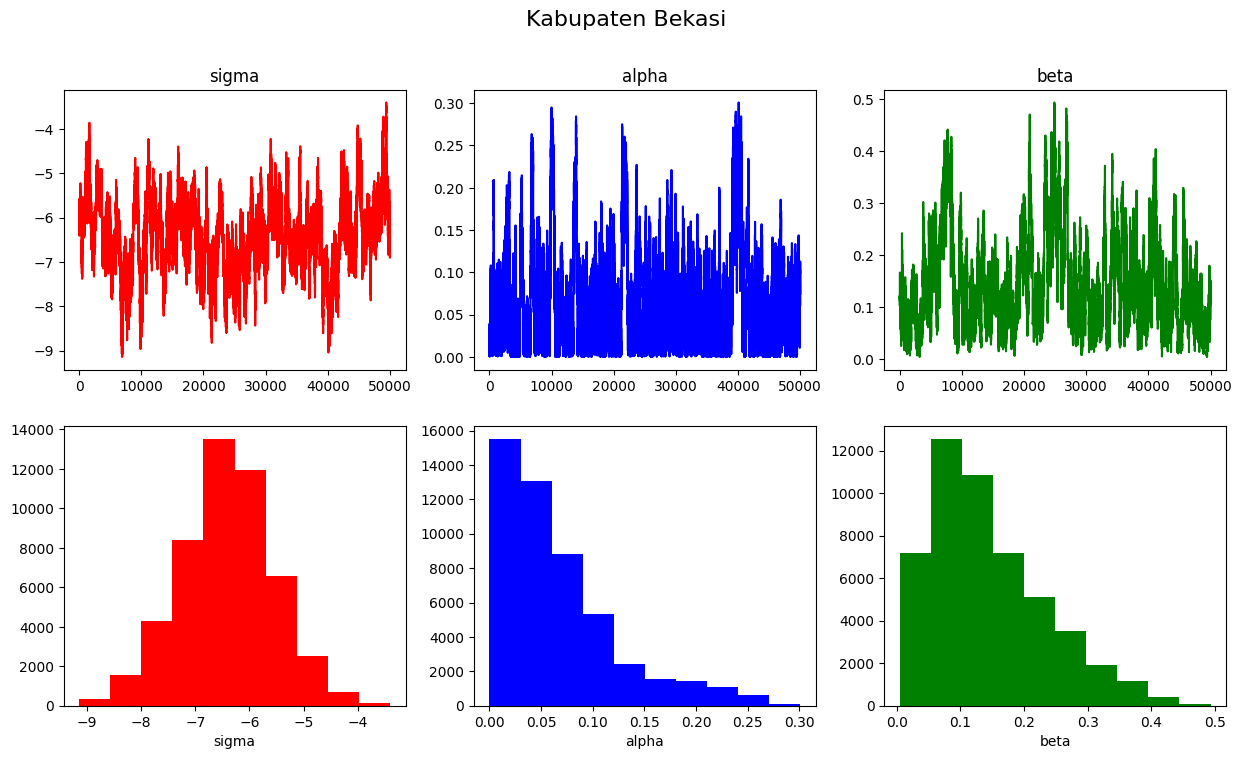

In [ ]:
# Visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(3):
    axs[0, i].plot(samples[int(burn):, i], color=["red", "blue", "green"][i])
    axs[0, i].set(title=["sigma", "alpha", "beta"][i])

for i in range(3):
    axs[1, i].hist(samples[int(burn):, i], color=["red", "blue", "green"][i])
    axs[1, i].set(xlabel=["sigma", "alpha", "beta"][i])
fig.suptitle("Kabupaten Bekasi", fontsize=16)
plt.show()

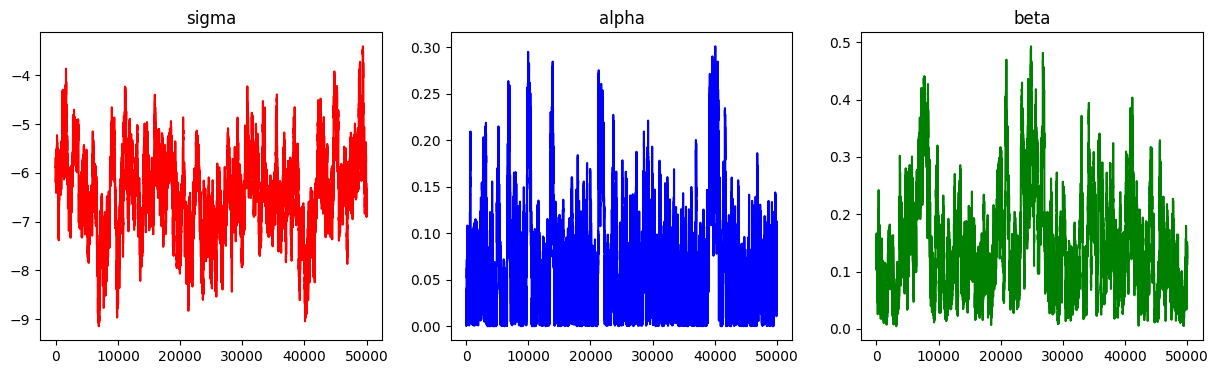

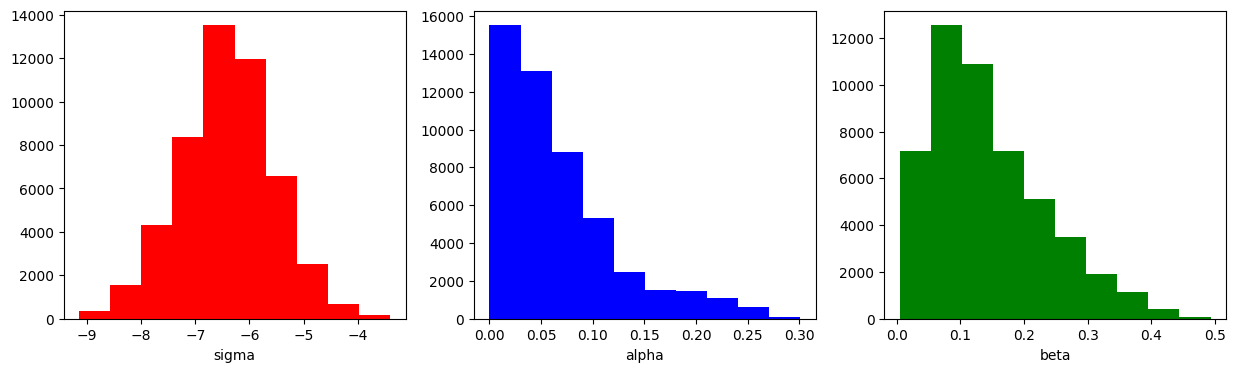

In [ ]:
# Visualization
fig, axs = plt.subplots(1,3, figsize  = (15,4))
axs[0].plot(samples[int(burn):,0], color="red")
axs[0].set(title="sigma")
axs[1].plot(samples[int(burn):,1], color="blue")
axs[1].set(title="alpha")
axs[2].plot(samples[int(burn):,2], color="green")
axs[2].set(title="beta")
plt.show()

fig, axs = plt.subplots(1,3, figsize  = (15,4))
axs[0].hist(samples[int(burn):,0], color="red")
axs[0].set(xlabel="sigma")
axs[1].hist(samples[int(burn):,1], color="blue")
axs[1].set(xlabel="alpha")
axs[2].hist(samples[int(burn):,2], color="green")
axs[2].set(xlabel="beta")
plt.show()

In [ ]:
np.mean(samples[int(burn):, 2])

0.14404390079379567

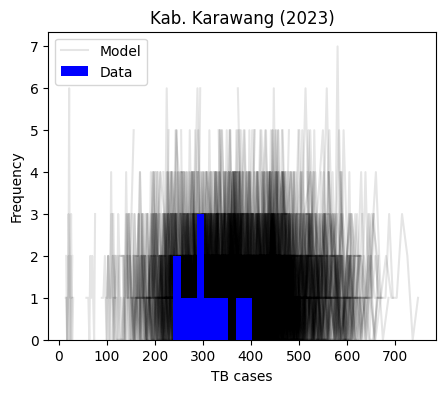

In [ ]:
# Model
def modelGen(Tb, x, N, sigma, alpha, beta):
    m = len(Tb)
    n = np.random.poisson(logistic(sigma + alpha*x)*N, m)
    y = np.random.binomial(n, beta)
    return y

NumSample = 1000
realizations = np.array([])
bins = np.array([])
histbar = np.array([])
for i in range(NumSample):
    Idx = random.randint(1, n_samples-burn)
    params = samples[int(burn)+Idx, :]
    realizations = np.append(realizations, modelGen(Tb[4], x[4],N[4], *params)).reshape(-1,len(Tb[0]))
    histbar_temp, bins_temp = np.histogram(modelGen(Tb[4], x[4], N[4], *params), bins=10)
    bins = np.append(bins, bins_temp).reshape(-1,len(bins_temp))
    histbar = np.append(histbar, histbar_temp).reshape(-1,len(histbar_temp))

# Visual
fig = plt.figure(figsize  = (5,4))
plt.plot(bins[0,:-1], histbar[0,:], color='black', alpha=0.1, label="Model")
for i in range(NumSample):
    plt.plot(bins[i,:-1], histbar[i,:], color='black', alpha=0.1)
plt.hist(Tb[4], zorder=10, color="blue", label="Data")
plt.xlabel("TB cases")
plt.ylabel("Frequency")
plt.title("Kab. Karawang (2023)")
plt.legend()
plt.show()

In [ ]:
realizations

array([[386., 359., 376., ..., 376., 390., 372.],
       [381., 370., 364., ..., 331., 384., 359.],
       [437., 428., 450., ..., 478., 487., 461.],
       ...,
       [354., 324., 392., ..., 336., 371., 347.],
       [206., 209., 197., ..., 191., 178., 162.],
       [569., 546., 568., ..., 540., 568., 571.]])

In [ ]:
Tb[0]

[1328, 1166, 1268, 1013, 1418, 1106, 1192, 1443, 1438, 1441, 1198, 988]

In [ ]:
realizations[1][2]

364.0

In [ ]:
predict= np.mean(realizations, axis=0)

In [ ]:
relative_error = abs(Tb[0]-predict)/np.sum(Tb[0])

In [ ]:
relative_error.mean()

0.057952530168677914

In [ ]:
posrate_mtb = np.array([25.44, 21.42, 22.14, 23.24, 27.11, 20.91, 20.40, 19.46, 17.93, 14.45, 13.31, 17.23])/100
posrate_rr = np.array([2.96, 3.76, 5.11, 8.24, 5.13, 8.12,9.86, 7.87, 7.9, 5.29, 6.09, 5.7])/100
gabung = posrate_mtb+posrate_rr

In [ ]:
np.mean(posrate_mtb)

0.20253333333333332

In [ ]:
np.mean(posrate_rr)

0.06335833333333332

In [ ]:
np.mean(gabung)

0.2658916666666667

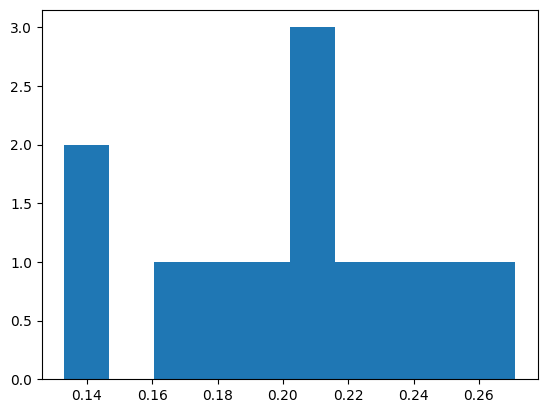

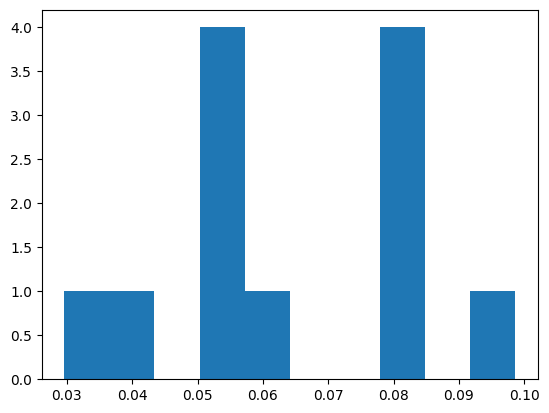

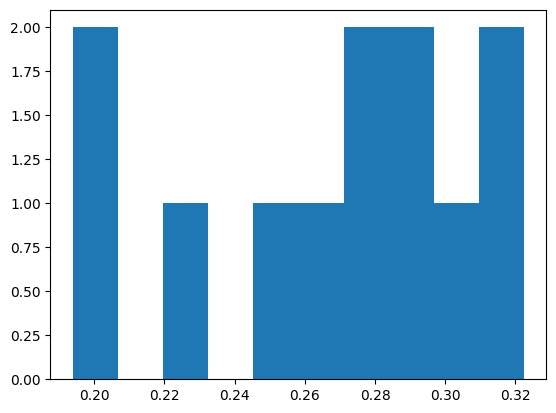

In [ ]:
plt.hist(posrate_mtb)
plt.show()
plt.hist(posrate_rr)
plt.show()
plt.hist(gabung)
plt.show()

In [ ]:
parameter = samples[int(burn):, :]
parameter

array([[-5.89374985,  0.0336073 ,  0.11323495],
       [-5.89580254,  0.01609958,  0.11738148],
       [-5.89580254,  0.01609958,  0.11738148],
       ...,
       [-6.85858065,  0.1101613 ,  0.1406566 ],
       [-6.6347408 ,  0.10471042,  0.13660038],
       [-6.54648776,  0.09882395,  0.12454965]])

In [ ]:
sigma = parameter[:,0]
alpha = parameter[:,1]
sigma

array([-5.89374985, -5.89580254, -5.89580254, ..., -6.85858065,
       -6.6347408 , -6.54648776])

In [ ]:
a = [1,2,3,4]
2*np.array(a)

array([2, 4, 6, 8])

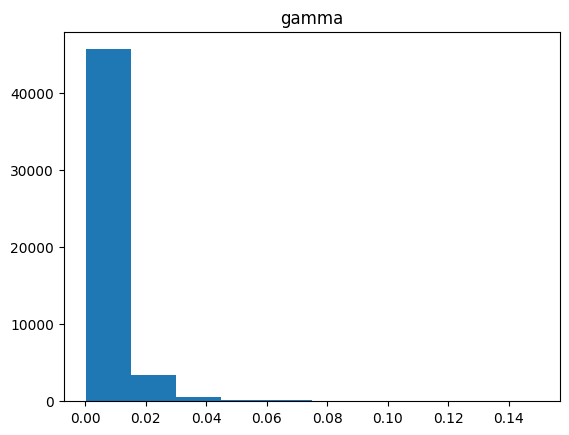

In [ ]:
gamma = logistic(sigma + alpha*x[0])
plt.hist(gamma)
plt.title("gamma")
plt.show()

In [ ]:
np.mean(gamma)

0.006766313258476568

In [ ]:
np.mean(gamma)*N[0] #model

25925.16308141926

In [ ]:
17861/N[0] #real

0.004661614691876952